In [6]:
from torch import nn
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import numpy as np
from numpy import loadtxt
from PIL import Image
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

import os
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torch.optim as optim
import time
import copy

In [7]:
DATASET = 'MINI'

In [8]:
def get_ds(root, max_size=1024):
    # Applying Transforms to the Data
    image_transform = transforms.Compose([
            transforms.Resize(size=(224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
    ])
    
    directories = {
        type_: os.path.join(root, type_) for type_ in next(os.walk(root))[1]
    }
    types = directories.keys()

    # Batch size
    bs = 4

    # Number of classes
    num_classes = 2

    # Load Data from folders
    ds = {
        type_: datasets.ImageFolder(root=directories[type_], transform=image_transform)
                                    for type_ in  directories
    }
    
    dls = {type_: torch.utils.data.DataLoader(ds[type_], batch_size=bs, shuffle=True, num_workers=4)
              for type_ in types
    }
    dls = {type_: {"dl": dls[type_], "size": len(ds[type_]), "cls": ds[type_].classes} for type_ in types}
    return dls

['correct', 'incorrect']


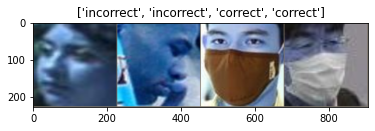

In [9]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

dataloaders = get_ds(DATASET)


class_names = dataloaders['train']['cls']
print(class_names)
inputs, classes = next(iter(dataloaders['train']['dl']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [12]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            full_len = len(dataloaders[phase]["dl"].dataset)
            completed = 0
            for inputs, labels in dataloaders[phase]["dl"]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                completed += len(labels)
                print(f"{completed}/{full_len}")
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataloaders[phase]["size"]
            epoch_acc = running_corrects.double() / dataloaders[phase]["size"]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
model = torchvision.models.resnet34(pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu");model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [14]:
# Model modification #
# ================== #
model.fc = nn.Linear(512, 2)

In [15]:
# Learning parameters #
# =================== #

model = model.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [16]:
model_trained = train_model(model, criterion, optimizer, scheduler, num_epochs=1)

Epoch 0/0
----------
4/128
8/128
12/128
16/128
20/128
24/128
28/128
32/128
36/128
40/128
44/128
48/128
52/128
56/128
60/128
64/128
68/128
72/128
76/128
80/128
84/128
88/128
92/128
96/128
100/128
104/128
108/128
112/128
116/128
120/128
124/128
128/128
train Loss: 0.5525 Acc: 0.6875
4/32
8/32
12/32
16/32
20/32
24/32
28/32
32/32
test Loss: 0.3485 Acc: 0.8750

Training complete in 0m 28s
Best val Acc: 0.875000
